# Repetition Code-Phase and Bit flip Channel

## 3 qubit Bit flip Code


Logical0 initial state
Runtime: 121.6 seconds


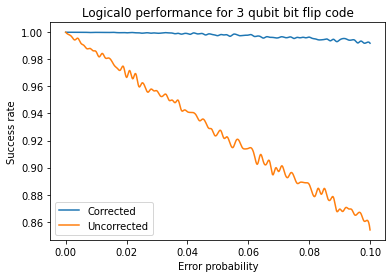


Logical+ initial state
Runtime: 114.4 seconds


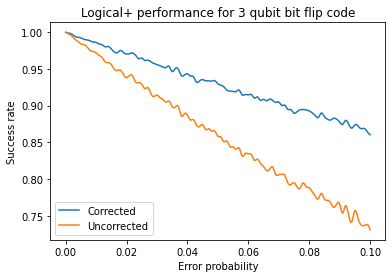


Average difference in success rates:
Logical0:  0.06992376237623762
Logical+:  0.06804455445544555

Average deviations from the ideal success rate (1.00):
Logical0:  0.002407920792079203
Logical+:  0.06998811881188119


In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer.noise import pauli_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 10000

q = QuantumRegister(5)              # Create 5-qubit quantum register
c = ClassicalRegister(2)            # Create 2-bit classical register
cr = ClassicalRegister(3)           # Create 3-bit classical register
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator

error_probs = np.arange(0, 0.101, 0.001)
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' chooses between |0> and |+> initial state
def scan_probs(init):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        bit_flip = QuantumCircuit(q, c)     # Create quantum circuit

        # Prepares qubit in the desired initial state
        # Encodes the qubit in a three-qubit entangled state
        if init == 'plus':
            bit_flip.h(q[0])
        bit_flip.cx(q[0], q[1])
        bit_flip.cx(q[0], q[2])

        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for i in range(0,3):
            bit_flip.append(error, [i])

        # Entangle two ancilla qubits for error-correction
        bit_flip.cx(q[0], q[3])
        bit_flip.cx(q[1], q[3])
        bit_flip.cx(q[1], q[4])
        bit_flip.cx(q[2], q[4])

        # Measure the two ancilla qubits
        bit_flip.measure(q[3], c[0])
        bit_flip.measure(q[4], c[1])

        # Do error correction
        bit_flip.x(q[0]).c_if(c,1)
        bit_flip.x(q[1]).c_if(c,3)
        bit_flip.x(q[2]).c_if(c,2)

        if init == 'plus':
            # Decode the qubit from the three-qubit entangled state
            bit_flip.cx(q[0], q[1])
            bit_flip.cx(q[0], q[2])
            bit_flip.h(q[0])

        # Add the classical register to the quantum circuit
        bit_flip.add_register(cr)
        # Check the state of the initial qubit
        for i in range(0,3):
            bit_flip.measure(q[i], cr[i])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(bit_flip, simulator, shots=Nshots,
                         seed_simulator=seed).result()

        # Get the counts from the result
        counts = result.get_counts()

        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:3] == '000':
                num_success += value
                if key == '000 00':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        #print("%.3g %.3g %.3g" % (p_err, success_rates[-1], uncorr_rates[-1]))

    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
success_rate_diffs = {'zero': [], 'plus': []}
deviations = {'zero': [], 'plus': []}
# Loop over |0> and |+> initial states
for state in ['zero', 'plus']:
    runtime = -time.time()
    if state == 'zero':
        print("Logical0 initial state")
    else:
        # Blank line in output to separate results
        print("\nLogical+ initial state")

    success_rates, uncorr_rates = scan_probs(state)
    
       
    # Calculate difference in success rates for each error probability
    success_rate_diff = [s - u for s, u in zip(success_rates, uncorr_rates)]
    success_rate_diffs[state] = success_rate_diff
   
    # Calculate deviation from the ideal success rate (1) for each error probability
    deviation = [1 - s for s in success_rates]
    deviations[state] = deviation

    # Print runtime here to ignore time spent looking at plot
    runtime += time.time()
    print("Runtime: %0.1f seconds" % runtime)

    if state == 'zero':
      title = 'Logical0 performance for 3 qubit bit flip code'
    else:
      title = 'Logical+ performance for 3 qubit bit flip code'

    success_spline = CubicSpline(error_probs, success_rates)
    uncorr_spline = CubicSpline(error_probs, uncorr_rates)

    # Generate finer x-axis values for smooth curves
    x_fine = np.linspace(error_probs.min(), error_probs.max(), 500)

    # Evaluate the spline functions at the finer x-axis values
    success_smooth = success_spline(x_fine)
    uncorr_smooth = uncorr_spline(x_fine)

    # Plot the smooth success rate and uncorrected rate curves
    plt.plot(x_fine, success_smooth, label='Corrected')
    plt.plot(x_fine, uncorr_smooth, label='Uncorrected')

#     # Add the original data points for reference
#     plt.scatter(error_probs, success_rates, marker='.', color='blue', alpha=0.5)
#     plt.scatter(error_probs, uncorr_rates, marker='.', color='orange', alpha=0.5)

    # Rest of the plotting code
    plt.title(title)
    plt.xlabel('Error probability')
    plt.ylabel('Success rate')
    plt.legend(loc='lower left')
    plt.show()

# ------------------------------------------------------------------

# Calculate average difference in success rates for Logical0 and Logical+ initial states
avg_diff_zero = np.mean(success_rate_diffs['zero'])
avg_diff_plus = np.mean(success_rate_diffs['plus'])

print("\nAverage difference in success rates:")
print("Logical0: ", avg_diff_zero)
print("Logical+: ", avg_diff_plus)

# Calculate average deviation for Logical0 and Logical+ initial states
avg_deviation_zero = np.mean(deviations['zero'])
avg_deviation_plus = np.mean(deviations['plus'])

print("\nAverage deviations from the ideal success rate (1.00):")
print("Logical0: ", avg_deviation_zero)
print("Logical+: ", avg_deviation_plus)

This code simulates a quantum error correction circuit to correct bit-flip errors on a single qubit. Each data qubit is sent through a Pauli error channel. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.01% at each iteration up to 10%. For each error probability, the code performs 1000 shots. 

# 3 Qubit Phase flip code


Logical0 initial state
Runtime: 137.1 seconds


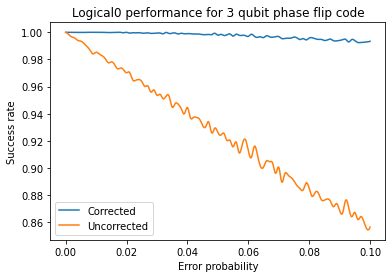


Logical+ initial state
Runtime: 158.1 seconds


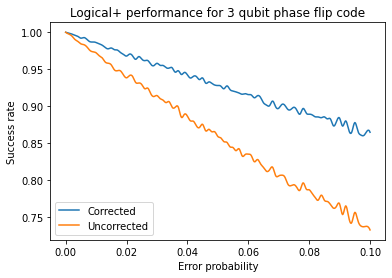


Average difference in success rates:
Logical0:  0.07043267326732675
Logical+:  0.06757227722772277

Average deviations from the ideal success rate (1.00):
Logical0:  0.002417821782178213
Logical+:  0.07041485148514853


In [2]:
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 10000

q = QuantumRegister(5)              # Create 5-qubit quantum register
c = ClassicalRegister(2)            # Create 2-bit classical register
cr = ClassicalRegister(3)           # Create 3-bit classical register
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator

error_probs = np.arange(0, 0.101, 0.001)
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' chooses between |0> and |+> initial state
def scan_probs(init):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        phase_flip = QuantumCircuit(q, c)     # Create quantum circuit

        # Prepares qubit in the desired initial state
        # Encodes the qubit in a three-qubit entangled state
        if init == 'plus':
            phase_flip.h(q[0])
        phase_flip.cx(q[0], q[1])
        phase_flip.cx(q[0], q[2])
        for i in range(0,3):
            phase_flip.h(q[i])
        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for i in range(0,3):
            phase_flip.append(error, [i])
        for i in range(0,3):
            phase_flip.h(q[i])
        # Entangle two ancilla qubits for error-correction
        phase_flip.cx(q[0], q[3])
        phase_flip.cx(q[1], q[3])
        phase_flip.cx(q[1], q[4])
        phase_flip.cx(q[2], q[4])

        # Measure the two ancilla qubits
        phase_flip.measure(q[3], c[0])
        phase_flip.measure(q[4], c[1])

        # Do error correction
        phase_flip.x(q[0]).c_if(c,1)
        phase_flip.x(q[1]).c_if(c,3)
        phase_flip.x(q[2]).c_if(c,2)

        if init == 'plus':
            # Decode the qubit from the three-qubit entangled state
            phase_flip.cx(q[0], q[1])
            phase_flip.cx(q[0], q[2])
            phase_flip.h(q[0])

        # Add the classical register to the quantum circuit
        phase_flip.add_register(cr)
        # Check the state of the initial qubit
        for i in range(0,3):
            phase_flip.measure(q[i], cr[i])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(phase_flip, simulator, shots=Nshots,
                         seed_simulator=seed).result()

        # Get the counts from the result
        counts = result.get_counts()

        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:3] == '000':
                num_success += value
                if key == '000 00':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        #print("%.3g %.3g %.3g" % (p_err, success_rates[-1], uncorr_rates[-1]))

    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
success_rate_diffs = {'zero': [], 'plus': []}
deviations = {'zero': [], 'plus': []}
# Loop over |0> and |+> initial states
for state in ['zero', 'plus']:
    runtime = -time.time()
    if state == 'zero':
        print("Logical0 initial state")
    else:
        # Blank line in output to separate results
        print("\nLogical+ initial state")

    success_rates, uncorr_rates = scan_probs(state)
    
       
    # Calculate difference in success rates for each error probability
    success_rate_diff = [s - u for s, u in zip(success_rates, uncorr_rates)]
    success_rate_diffs[state] = success_rate_diff
   
    # Calculate deviation from the ideal success rate (1) for each error probability
    deviation = [1 - s for s in success_rates]
    deviations[state] = deviation

    # Print runtime here to ignore time spent looking at plot
    runtime += time.time()
    print("Runtime: %0.1f seconds" % runtime)

    if state == 'zero':
      title = 'Logical0 performance for 3 qubit phase flip code'
    else:
      title = 'Logical+ performance for 3 qubit phase flip code'

    success_spline = CubicSpline(error_probs, success_rates)
    uncorr_spline = CubicSpline(error_probs, uncorr_rates)

    # Generate finer x-axis values for smooth curves
    x_fine = np.linspace(error_probs.min(), error_probs.max(), 500)

    # Evaluate the spline functions at the finer x-axis values
    success_smooth = success_spline(x_fine)
    uncorr_smooth = uncorr_spline(x_fine)

    
    # Plot the success rate as a function of the error probability
    # Plot the smooth success rate and uncorrected rate curves
    plt.plot(x_fine, success_smooth, label='Corrected')
    plt.plot(x_fine, uncorr_smooth, label='Uncorrected')

    plt.title(title)
    plt.xlabel('Error probability')
    plt.ylabel('Success rate')
    plt.legend(loc='lower left')
    plt.show()
#--------------------------------------------------------------------------

# Calculate average difference in success rates for Logical0 and Logical+ initial states
avg_diff_zero = np.mean(success_rate_diffs['zero'])
avg_diff_plus = np.mean(success_rate_diffs['plus'])

print("\nAverage difference in success rates:")
print("Logical0: ", avg_diff_zero)
print("Logical+: ", avg_diff_plus)

# Calculate average deviation for Logical0 and Logical+ initial states
avg_deviation_zero = np.mean(deviations['zero'])
avg_deviation_plus = np.mean(deviations['plus'])

print("\nAverage deviations from the ideal success rate (1.00):")
print("Logical0: ", avg_deviation_zero)
print("Logical+: ", avg_deviation_plus)

This code simulates a quantum error correction circuit to correct phase-flip errors on a single qubit. Each data qubit is sent through a Pauli error channel. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.01% at each iteration up to 10%. For each error probability, the code performs 1000 shots. 

# Shor Code


Logical0 initial state
Runtime: 619.4 seconds


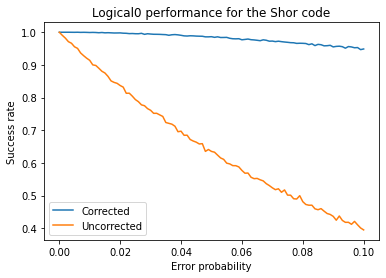


Logical+ initial state
Runtime: 560.7 seconds


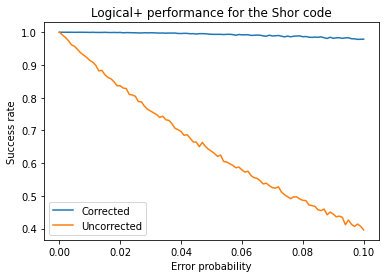


Average difference in success rates:
Logical0:  0.3257128712871287
Logical+:  0.33533564356435647

Average deviations from the ideal success rate (1.00):
Logical0:  0.018298019801980193
Logical+:  0.007249504950495053


In [4]:
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 10000

q = QuantumRegister(17)             # Create 17-qubit quantum register
c = ClassicalRegister(2)            # Create 2-bit classical register
c1 = ClassicalRegister(2)           # Create 2-bit classical register
c2 = ClassicalRegister(2)           # Create 2-bit classical register
c3 = ClassicalRegister(2) 
c4 = ClassicalRegister(9)           # Create 9-bit classical register to measure data qubits
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator

error_probs = np.arange(0, 0.101, 0.001)
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' chooses between |0> and |+> initial state
def scan_probs(init):
    success_rates = []
    uncorr_rates = []
    for p_err in error_probs:
        shor = QuantumCircuit(q, c)     # Create quantum circuit

        # Prepares qubit in the desired initial state
        # Encodes the qubit in a nine-qubit entangled state
        if init == 'plus':
            shor.h(q[0])
        shor.cx(q[0], q[3])
        shor.cx(q[0], q[6])
        shor.h(q[0])
        shor.h(q[3])
        shor.h(q[6])
        for i in range(1,3):
            shor.cx(0,i)
        for j in range(4,6):
            shor.cx(3,j)
        for k in range(7,9):
            shor.cx(6,k)
        # Construct a 1-qubit bit-flip or phase-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for i in range(0,9):
            shor.append(error, [i])
       #Entangle with bit flip ancilla qubits
        #First block
        shor.cx(q[0],q[9])
        shor.cx(q[1],q[9])
        shor.cx(q[1],q[10])
        shor.cx(q[2],q[10])
        # Measure the two additional qubits
        shor.measure(q[9], c[0])
        shor.measure(q[10], c[1])

        # Do error correction
        shor.x(q[0]).c_if(c,1)
        shor.x(q[1]).c_if(c,3)
        shor.x(q[2]).c_if(c,2)

        # Add the classical register to the quantum circuit
        shor.add_register(c1)
        #Second block
        shor.cx(q[3],q[11])
        shor.cx(q[4],q[11])
        shor.cx(q[4],q[12])
        shor.cx(q[5],q[12])
        # Measure the two additional qubits
        shor.measure(q[11], c1[0])
        shor.measure(q[12], c1[1])

        # Do error correction
        shor.x(q[3]).c_if(c1,1)
        shor.x(q[4]).c_if(c1,3)
        shor.x(q[5]).c_if(c1,2)


        # Add the classical register to the quantum circuit
        shor.add_register(c2)
        #Third block
        shor.cx(q[6],q[13])
        shor.cx(q[7],q[13])
        shor.cx(q[7],q[14])
        shor.cx(q[8],q[14])

        # Measure the two additional qubits
        shor.measure(q[13], c2[0])
        shor.measure(q[14], c2[1])

        # Do error correction
        shor.x(q[6]).c_if(c2,1)
        shor.x(q[7]).c_if(c2,3)
        shor.x(q[8]).c_if(c2,2)
        # Add the classical register to the quantum circuit
        shor.add_register(c3)
        #phase flip syndrome measurements
        for i in range(9):
            shor.h(q[i])
        #Entangle with ancillas
        for i in range(6):
            shor.cx(q[i],q[15])
        for i in range(3,9):
            shor.cx(q[i],q[16])

        # Measure the two additional qubits
        shor.measure(q[15], c3[0])
        shor.measure(q[16], c3[1])

        #Back into x basis
        for i in range(9):
            shor.h(q[i])
        # Do error correction
        shor.z(q[0]).c_if(c3,1)
        shor.z(q[3]).c_if(c3,3)
        shor.z(q[6]).c_if(c3,2)
        #Decode
        for i in range(1,3):
            shor.cx(q[0],q[i])
        for j in range(4,6):
            shor.cx(q[3],q[j])
        for k in range(7,9):
            shor.cx(q[6],q[k])
        shor.h(q[0])
        shor.h(q[3])
        shor.h(q[6])
        shor.cx(q[0],q[3])
        shor.cx(q[0],q[6])
        if init == 'plus':
            shor.h(q[0])

        #Now measure the code qubits to see if the error was corrected successfully
        shor.add_register(c4)
        for i in range(9):
            shor.measure(q[i],c4[i])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(shor, simulator, shots=Nshots,
                         seed_simulator=seed).result()

        # Get the counts from the result
        counts = result.get_counts()

        num_success = 0
        raw_success = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key[:9] == '000000000':
                num_success += value
                if key == '000000000 00 00 00 00':     # Correct without correction
                    raw_success += value
        success_rates.append(num_success / float(Nshots))
        uncorr_rates.append(raw_success / float(Nshots))
        #print("%.3g %.3g %.3g" % (p_err, success_rates[-1], uncorr_rates[-1]))

    return success_rates, uncorr_rates
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Main code
success_rate_diffs = {'zero': [], 'plus': []}
deviations = {'zero': [], 'plus': []}
# Loop over |0> and |+> initial states
for state in ['zero', 'plus']:
    runtime = -time.time()
    if state == 'zero':
        print("Logical0 initial state")
    else:
        # Blank line in output to separate results
        print("\nLogical+ initial state")

    success_rates, uncorr_rates = scan_probs(state)

    # Calculate difference in success rates for each error probability
    success_rate_diff = [s - u for s, u in zip(success_rates, uncorr_rates)]
    success_rate_diffs[state] = success_rate_diff
   
    # Calculate deviation from the ideal success rate (1) for each error probability
    deviation = [1 - s for s in success_rates]
    deviations[state] = deviation

    # Print runtime here to ignore time spent looking at plot
    runtime += time.time()
    print("Runtime: %0.1f seconds" % runtime)
    
    success_spline = CubicSpline(error_probs, success_rates)
    uncorr_spline = CubicSpline(error_probs, uncorr_rates)

    # Generate finer x-axis values for smooth curves
    x_fine = np.linspace(error_probs.min(), error_probs.max(), 500)

    # Evaluate the spline functions at the finer x-axis values
    success_smooth = success_spline(x_fine)
    uncorr_smooth = uncorr_spline(x_fine)

    
    if state == 'zero':
      title = 'Logical0 performance for the Shor code'
    else:
      title = 'Logical+ performance for the Shor code'

    # Plot the success rate as a function of the error probability
    # TODO: ADD UNCORRECTED VS CORRECTED...
    plt.plot(error_probs, success_rates, label='Corrected')
    plt.plot(error_probs, uncorr_rates, label='Uncorrected')
    plt.title(title)
    plt.xlabel('Error probability')
    plt.ylabel('Success rate')
    plt.legend(loc='lower left')
    plt.show()
    
#--------------------------------------------------------------------------

# Calculate average difference in success rates for Logical0 and Logical+ initial states
avg_diff_zero = np.mean(success_rate_diffs['zero'])
avg_diff_plus = np.mean(success_rate_diffs['plus'])

print("\nAverage difference in success rates:")
print("Logical0: ", avg_diff_zero)
print("Logical+: ", avg_diff_plus)

# Calculate average deviation for Logical0 and Logical+ initial states
avg_deviation_zero = np.mean(deviations['zero'])
avg_deviation_plus = np.mean(deviations['plus'])

print("\nAverage deviations from the ideal success rate (1.00):")
print("Logical0: ", avg_deviation_zero)
print("Logical+: ", avg_deviation_plus)

This code simulates the Shor code. Each data qubit is sent through a Pauli error channel. It performs error correction at increasing error probabilities, starting from 0% and increasing by 0.01% at each itera tion up to 10%. For each error probability, the code performs 1000 shots. 

# Repetition Code- Simulating on Real device model

## Hellinger Fidelities
### Bit Flip code

In [21]:
from qiskit_aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel

# Example error probabilities
p_meas = 0.1
p_gate1 = 0.001

# QuantumError objects
error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z', 0.5*p_gate1),('X', 0.5*p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()

# noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
for i in range(0,3):
    noise_bit_flip.add_quantum_error(error_gate1, ["u1", "u2", "u3"], [i])
    
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'u1', 'u2']
  Qubits with noise: [0, 1, 2]
  All-qubits errors: ['cx']
  Specific qubit errors: [('u1', (0,)), ('u1', (1,)), ('u1', (2,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,))]


In [22]:
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeAuckland
from qiskit.visualization import plot_histogram
from qiskit import *
from collections import defaultdict
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator
q = QuantumRegister(5)

# Create a classical register with 5 bits
c = ClassicalRegister(2)
# Prepares qubit in the desired initial state 
for i in['zero', 'plus']:
    # Create a quantum circuit
    bit_flip = QuantumCircuit(q, c)
    if i == 'plus':
        bit_flip.h(q[0])
    # Encodes the qubit in a three-qubit entangled state  
    bit_flip.cx(q[0], q[1])
    bit_flip.cx(q[0], q[2])
    # Adds additional two qubits for error-correction
    bit_flip.cx(q[0], q[3])
    bit_flip.cx(q[1], q[3])
    bit_flip.cx(q[1], q[4])
    bit_flip.cx(q[2], q[4])
    
    # Measure the two additional qubits
    bit_flip.measure(q[3], c[0])
    bit_flip.measure(q[4], c[1])

    # Do error correction
    bit_flip.x(q[0]).c_if(c,1)
    bit_flip.x(q[1]).c_if(c,3)
    bit_flip.x(q[2]).c_if(c,2)

#     Decodes the qubit from the three-qubit entangled state  
    bit_flip.cx(q[0], q[1])
    bit_flip.cx(q[0], q[2])
    
    if i == 'plus':
        bit_flip.h(q[0])

    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)
    
    # Add the classical register to the quantum circuit
    bit_flip.add_register(cr)
    # Check the state of the initial qubit
    for j in range(0,3):
        bit_flip.measure(q[j], cr[j])
        
    
    circ_tnoise = transpile(bit_flip, sim_noise)
    # Run and get counts
    noisy_result = sim_noise.run(circ_tnoise, shots = 1000).result()
    noisy_counts = noisy_result.get_counts(0)
    
    # Create a defaultdict to group counts with the same binary values
    actual_sliced_counts = defaultdict(int)

    # Iterate over each key-value pair in actual_counts and add the count to the corresponding grouped key
    for key, value in noisy_counts.items():
        grouped_key = key[:3] # Slice the key to ignore ancilla qubits
        actual_sliced_counts[grouped_key] += value

    # Convert the defaultdict to a regular dictionary
    actual_sliced_counts = dict(actual_sliced_counts)
    print(actual_sliced_counts)
    #Execute Ideal Simulation
    result = execute(bit_flip, simulator, shots = 1000).result()
    # Get the counts from the result
    ideal_counts = result.get_counts()
    ideal_sliced_counts = {key[:3]: value for key, value in ideal_counts.items()}
    fidelity = hellinger_fidelity(ideal_sliced_counts, actual_sliced_counts)                       
    print(f"Hellinger fidelity for logical {i} state: {fidelity:.3f}")

{'110': 1, '010': 1, '000': 995, '100': 3}
Hellinger fidelity for logical zero state: 0.99
{'000': 985, '100': 2, '010': 2, '001': 10, '110': 1}
Hellinger fidelity for logical plus state: 0.99


### Phase Flip Code

In [23]:
q = QuantumRegister(5)

# Create a classical register with 5 bits
c = ClassicalRegister(2)
# Create a classical register with 3 bits
cr = ClassicalRegister(3)

# Create a quantum circuit
phase_flip = QuantumCircuit(q, c)

# Prepares qubit in the desired initial state 
for i in['zero', 'plus']:
    if i == 'plus':
        phase_flip.h(q[0])
    phase_flip.cx(q[0], q[1])
    phase_flip.cx(q[0], q[2])
    for k in range(0,3):
        phase_flip.h(q[k])

    for k in range(0,3):
        phase_flip.h(q[k])
    # Entangle two ancilla qubits for error-correction
    phase_flip.cx(q[0], q[3])
    phase_flip.cx(q[1], q[3])
    phase_flip.cx(q[1], q[4])
    phase_flip.cx(q[2], q[4])

    # Measure the two ancilla qubits
    phase_flip.measure(q[3], c[0])
    phase_flip.measure(q[4], c[1])

    # Do error correction
    phase_flip.x(q[0]).c_if(c,1)
    phase_flip.x(q[1]).c_if(c,3)
    phase_flip.x(q[2]).c_if(c,2)

    if i == 'plus':
        # Decode the qubit from the three-qubit entangled state
        phase_flip.cx(q[0], q[1])
        phase_flip.cx(q[0], q[2])
        phase_flip.h(q[0])
    
    # Create a classical register with 3 bits
    cr = ClassicalRegister(3)

    # Add the classical register to the quantum circuit
    phase_flip.add_register(cr)
    # Check the state of the initial qubit
    for j in range(0,3):
        phase_flip.measure(q[j], cr[j])
        
    circ_tnoise = transpile(phase_flip, sim_noise)
    # Run and get counts
    noisy_result = sim_noise.run(circ_tnoise, shots = 1000).result()
    noisy_counts = noisy_result.get_counts(0)
    
    # Create a defaultdict to group counts with the same binary values
    actual_sliced_counts = defaultdict(int)

    # Iterate over each key-value pair in actual_counts and add the count to the corresponding grouped key
    for key, value in noisy_counts.items():
        grouped_key = key[:3] # Slice the key to ignore ancilla qubits
        actual_sliced_counts[grouped_key] += value

    # Convert the defaultdict to a regular dictionary
    actual_sliced_counts = dict(actual_sliced_counts)
    print(actual_sliced_counts)
    #Execute Ideal Simulation
    result = execute(phase_flip, simulator, shots = 1000).result()
    # Get the counts from the result
    ideal_counts = result.get_counts()
    ideal_sliced_counts = {key[:3]: value for key, value in ideal_counts.items()}
    fidelity = hellinger_fidelity(ideal_sliced_counts, actual_sliced_counts)
    print(f"Hellinger fidelity for logical {i} state: {fidelity:.2f}")

{'010': 1, '000': 997, '100': 2}
Hellinger fidelity for logical zero state: 1.00
{'100': 3, '001': 12, '111': 2, '000': 976, '010': 1, '011': 2, '110': 4}
Hellinger fidelity for logical plus state: 0.98


### Shor Code

In [44]:
# Example error probabilities
p_meas = 0.1
p_gate1 = 0.001

# QuantumError objects
error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z', 0.5*p_gate1),('X', 0.5*p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_shor = NoiseModel()

# noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
for i in range(0,9):
    noise_shor.add_quantum_error(error_gate1, ["u1", "u2", "u3"], [i])
    
noise_shor.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_shor)

print(noise_bit_flip)




q = QuantumRegister(17)             # Create 17-qubit quantum register
c = ClassicalRegister(2)            # Create 2-bit classical register
c1 = ClassicalRegister(2)           # Create 2-bit classical register
c2 = ClassicalRegister(2)           # Create 2-bit classical register
c3 = ClassicalRegister(2) 
c4 = ClassicalRegister(9) 



for i in['zero', 'plus']:
    shor = QuantumCircuit(q, c)     # Create quantum circuit

    # Prepares qubit in the desired initial state
    # Encodes the qubit in a nine-qubit entangled state
    if i == 'plus':
        shor.h(q[0])
    shor.cx(q[0], q[3])
    shor.cx(q[0], q[6])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])
    for j in range(1,3):
        shor.cx(0,j)
    for j in range(4,6):
        shor.cx(3,j)
    for k in range(7,9):
        shor.cx(6,k)
    
    
   #Entangle with bit flip ancilla qubits
    #First block
    shor.cx(q[0],q[9])
    shor.cx(q[1],q[9])
    shor.cx(q[1],q[10])
    shor.cx(q[2],q[10])
    # Measure the two additional qubits
    shor.measure(q[9], c[0])
    shor.measure(q[10], c[1])

    # Do error correction
    shor.x(q[0]).c_if(c,1)
    shor.x(q[1]).c_if(c,3)
    shor.x(q[2]).c_if(c,2)

    # Add the classical register to the quantum circuit
    shor.add_register(c1)
    #Second block
    shor.cx(q[3],q[11])
    shor.cx(q[4],q[11])
    shor.cx(q[4],q[12])
    shor.cx(q[5],q[12])
    # Measure the two additional qubits
    shor.measure(q[11], c1[0])
    shor.measure(q[12], c1[1])

    # Do error correction
    shor.x(q[3]).c_if(c1,1)
    shor.x(q[4]).c_if(c1,3)
    shor.x(q[5]).c_if(c1,2)


    # Add the classical register to the quantum circuit
    shor.add_register(c2)
    #Third block
    shor.cx(q[6],q[13])
    shor.cx(q[7],q[13])
    shor.cx(q[7],q[14])
    shor.cx(q[8],q[14])

    # Measure the two additional qubits
    shor.measure(q[13], c2[0])
    shor.measure(q[14], c2[1])

    # Do error correction
    shor.x(q[6]).c_if(c2,1)
    shor.x(q[7]).c_if(c2,3)
    shor.x(q[8]).c_if(c2,2)
    # Add the classical register to the quantum circuit
    shor.add_register(c3)
    #phase flip syndrome measurements
    for j in range(9):
        shor.h(q[j])
    #Entangle with ancillas
    for k in range(6):
        shor.cx(q[k],q[15])
    for l in range(3,9):
        shor.cx(q[l],q[16])

    # Measure the two additional qubits
    shor.measure(q[15], c3[0])
    shor.measure(q[16], c3[1])

    #Back into x basis
    for m in range(9):
        shor.h(q[m])
    # Do error correction
    shor.z(q[0]).c_if(c3,1)
    shor.z(q[3]).c_if(c3,3)
    shor.z(q[6]).c_if(c3,2)
    #Decode
    for l in range(1,3):
        shor.cx(q[0],q[l])
    for j in range(4,6):
        shor.cx(q[3],q[j])
    for k in range(7,9):
        shor.cx(q[6],q[k])
    shor.h(q[0])
    shor.h(q[3])
    shor.h(q[6])
    shor.cx(q[0],q[3])
    shor.cx(q[0],q[6])
    if i == 'plus':
        shor.h(q[0])

    #Now measure the code qubits to see if the error was corrected successfully
    shor.add_register(c4)
    for k in range(9):
        shor.measure(q[k],c4[k])

    # Choose a simulator
    tcirc = transpile(shor, sim_noise)

    # Execute noisy simulation and get counts
    result_noise = sim_noise.run(tcirc, shots = 1000).result()
    #Get the counts from the result
    actual_counts = result_noise.get_counts(0)
    # Create a defaultdict to group counts with the same binary values
    actual_sliced_counts = defaultdict(int)

    # Iterate over each key-value pair in actual_counts and add the count to the corresponding grouped key
    for key, value in actual_counts.items():
        grouped_key = key[:9] # Slice the key to ignore ancilla qubits
        actual_sliced_counts[grouped_key] += value

    # Convert the defaultdict to a regular dictionary
    actual_sliced_counts = dict(actual_sliced_counts)
#     print(actual_sliced_counts)
    #Execute Ideal Simulation
    result = execute(shor, simulator, shots = 1000).result()

    # Get the counts from the result
    ideal_counts = result.get_counts() 
    #Slice counts to ignore ancilla qubits
    ideal_sliced_counts = {key[:9]: value for key, value in ideal_counts.items()}
#     print(ideal_sliced_counts)
    fidelity = hellinger_fidelity(ideal_sliced_counts, actual_sliced_counts)
    print(f"Hellinger fidelity for logical {i} state: {fidelity:.3f}")

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'u1', 'u2']
  Qubits with noise: [0, 1, 2]
  All-qubits errors: ['cx']
  Specific qubit errors: [('u1', (0,)), ('u1', (1,)), ('u1', (2,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,))]
Hellinger fidelity for logical zero state: 0.941
Hellinger fidelity for logical plus state: 0.933


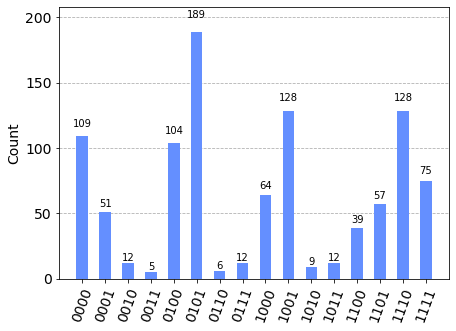

In [43]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.quantum_info import Statevector



# Define the simulator object
simulator = Aer.get_backend('qasm_simulator')

# Define the quantum circuit
qc = QuantumCircuit(9, 4)

qc.initialize(statevector.data, [4,5, 6, 7, 8])

for i in range(0, 4):
    qc.h(i)

qc.cx(0, 4)
qc.cx(2, 4)
qc.cz(3, 4)

qc.cz(0, 5)
qc.cx(1, 5)
qc.cx(3, 5)

qc.cz(0, 6)
qc.cz(1, 6)
qc.cx(2, 6)

qc.cx(0, 7)
qc.cz(1, 7)
qc.cz(2, 7)
qc.cx(3, 7)

qc.cx(1, 8)
qc.cz(2, 8)
qc.cz(3, 8)

for i in range(0, 4):
    qc.h(i)


for i in range(0,4):
    qc.measure(i,i)
# Draw the quantum circuit
qc.draw('mpl')

# Execute the quantum circuit on the simulator and get the result
result = execute(qc, simulator, shots=1000).result()

# Get the counts from the result
counts = result.get_counts(0)

# Plot the histogram of the counts
plot_histogram(counts)
